# The formation of compact dwarf galaxies in TNG50 #

In this notebook I present how to acces the data used for the paper "What drives the corpulence of galaxies? I. The formation of compact dwarf galaxies in TNG50" by de Almeida and Mamon 2023. 


## Make the Selection #
To make the selection we first get the stellar mass, stellar mass at half-stellar mass radius and the half-stellar mass radius (hereafter half-mass radius or \$ r_{1/2} $) for all subhalos in IllustrisTNG50 (TNG50, Nelson et al. 2019; Pillepich et al. 2019). Also we get the SubhaloFlag, where in general if 0 the subhalo should generally be excluded, since can not have cosmological origin. For all subhalos we compute the Surface Mass Density in \$ r_{1/2} \$: <br>
\begin{align}
\ \Sigma = \frac{ M_{r_{1/2}} }{\pi r_{1/2}^2.} \
\end{align} <br>
and, with that, we make the file './data/SAMPLE/All.pkl' where we indicates also the SubfindID for each subhalo. To acces this as a dataframe we can do:

In [1]:
import WorkSample as WkS
dfAll = WkS.extractDF('Samples/All')

All physical values in this dataframe are in log, with base units of \$ \mathrm{M_\odot}\$ and kpc. With that we reduced this selection by take only the galaxies betwee \$ 8 < \log{M} < 10\$. 

In [2]:
dfSample = dfAll.loc[dfAll.SubhaloMassInRadType4.between(8, 10)]

After that we start to make the selection. We only work with galaxies between  \$ 8.3 < \log{M} < 9.3\$. The <em>Compacts</em> are galaxies with \$\log r_{1/2} < -0.35$. With the galaxies above this size we compute the median mass - size relation and select the control sample as the galaxies that follow this relation and are between \$ 5^{\mathrm{th}} - 95^{\mathrm{th}}\$. 

In [3]:
import MATH
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#Galaxies above the Compact size
LargeSize = dfSample.loc[(dfSample.SubhaloMassInRadType4.between(8.3, 9.3)) & (dfSample.SubhaloHalfmassRadType4 >= -0.35) & (dfSample.Flags == 1)]
sizesControl = np.array([10**values for values in LargeSize.SubhaloHalfmassRadType4.values])
MassesControl = np.array([10**values for values in LargeSize.SubhaloMassInRadType4.values])

#Compute the median mass - size relation and take the 5th and 95 quantiles. These split the stellar mass range in 20 bins.

xmean, HalfRadmedian, HalfRadquantile95, HalfRadquantile5 = MATH.split_quantiles(MassesControl ,sizesControl, total_bins= 20, quantile = 0.95)
xmean = np.log10(xmean)
HalfRadmedian = np.log10(HalfRadmedian)
HalfRadquantile95 = np.log10(HalfRadquantile95)
HalfRadquantile5 = np.log10(HalfRadquantile5)

#Define the Samples

dfSample['Samples'] = ''

for i, x in enumerate(xmean):
    if i == 0:
        continue
    else:
        dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4.between(HalfRadquantile5[i], HalfRadquantile95[i])) & (dfSample.Flags == 1)] = 'ControlSample'
        dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile95[i]) & (dfSample.Flags == 1)] = 'LargeSizes'
        dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4.between(-0.35, HalfRadquantile5[i])) & (dfSample.Flags == 1)] = 'SmallSizes'

dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4.between(8.3, 9.3)) & 
               (dfSample.SubhaloHalfmassRadType4 < -0.35) & (dfSample.Flags == 1)] = 'Compact'
        
dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4 < 8.3) & (dfSample.Flags == 1)] = 'LowerMasses'
dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4 > 9.3) & (dfSample.Flags == 1)] = 'HigherMasses'

for i, x in enumerate(xmean):
    if i == 0:
        continue
    else:
        dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4.between(HalfRadquantile5[i], HalfRadquantile95[i])) & (dfSample.Flags != 1)] = 'ControlSampleBadFlag'
        dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile95[i]) & (dfSample.Flags != 1)] = 'DiffuseBadFlag'
        dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4.between(-0.35, HalfRadquantile5[i])) & (dfSample.Flags != 1)] = 'SmallSizesBadFlag'

dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4.between(8.3, 9.3)) & 
               (dfSample.SubhaloHalfmassRadType4 < -0.35) & (dfSample.Flags != 1)] = 'CompactBadFlag'
        
dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4 < 8.3) & (dfSample.Flags != 1)] = 'LowerMassesBadFlag'
dfSample.Samples.loc[(dfSample.SubhaloMassInRadType4 > 9.3) & (dfSample.Flags != 1)] = 'HigherMassesBadFlag'
dfSample.to_pickle('./data/Samples/Sample.pkl')     


We can visualize the sample selection doing

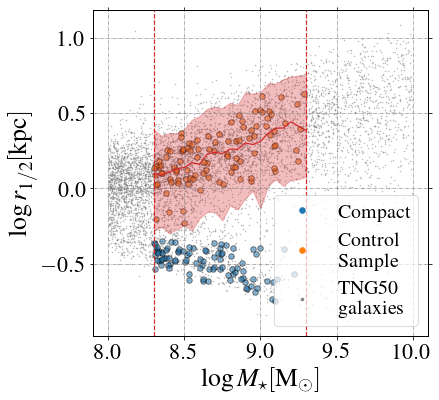

In [4]:
import plot
plot.PlotScatter(['Compact', 'ControlSample'], [''], 'SubhaloMassInRadType4', ['SubhaloHalfmassRadType4'], Type = 'Sample', SampleName='Samples' , dfName= 'Sample',medianSample= True , savefigname='MassSize', title=False, All='All', legend=True, LegendNames=[['CompactScatter', 'ControlSampleScatter', 'TNGrageScatter']]
                 , fontlegend= 20, framealpha = 0.7)


To identify the central and satellite galaxies we use the IDs for each subhalo and verify if this match with the first ID in the halo (with corresponds to the central subhalo in the halo). We also check if the central galaxy has already interacted with a group or not by checking the evolution of \$M_{200}\$ (i.e. mass in a sphere whose mean density is 200 times the critical density of the Universe) and, if it interacted, we define it as a satellite (e.g. a backsplash galaxy). In './data/Evolution/' we have '.pkl' for the evolution of different physical parameters that we have downloaded from both the main catalog and supplementary catalogs and organized for easy access. In each file we have the data for each galaxy in dfSample. <br>
With that we compute the evolution of the orbit radius for all satellites and make the file './data/Evolution/r_over_R_Crit200.pkl', where 0 means that the galaxy is a central. Therefore we can use these file to split the galaxy between central and satellite. 

In [5]:
r_over_R_Crit200 = WkS.extractDF('Evolution/r_over_R_Crit200')
dfSample['CentralSatellite'] = ''

for key in r_over_R_Crit200.keys():
    if key == 'Snap':
        continue
    else:
        if r_over_R_Crit200[key].values[0] == 0.:
            dfSample['CentralSatellite'].loc[dfSample.SubfindID == int(key)] = 'Central'
        elif r_over_R_Crit200[key].values[0] > 0:
            dfSample['CentralSatellite'].loc[dfSample.SubfindID == int(key)] = 'Satellite'

            
dfSample.to_pickle('./data/Samples/Sample.pkl')    

We also split the galaxies between <em>Compacts</em> and different quantiles:
<ul>
<li>Normal : galaxies that follows the median
mass - size relation and are within 32th − 68th in terms of
the size distribution;
<li>68th − 95th : galaxies that follows the median
mass - size relation and are within 68th − 95th in terms of the
size distribution;
<li>95th − 99th : galaxies that follows the median
mass - size relation and are within 95th − 99th in terms of the
size distribution;
<li> > 99th : galaxies that follows the median mass -
size relation and are > 99th in terms of the size distribution;
<li>5th − 32th : galaxies that follows the median
mass - size relation and are within 5th − 32th in terms of the
size distribution;
<li>1th −5th : galaxies that follows the median mass
- size relation and are within 1th − 5th in terms of the size
distribution;
<li>< 1th : galaxies that follows the median mass -
size relation and are < 1th in terms of the size distribution;
</ul>

In [6]:
xmean, HalfRadmedian, HalfRadquantile68, HalfRadquantile32 = MATH.split_quantiles(MassesControl ,sizesControl, total_bins= 20, quantile = 0.68)
xmean, HalfRadmedian, HalfRadquantile95, HalfRadquantile5 = MATH.split_quantiles(MassesControl ,sizesControl, total_bins= 20, quantile = 0.95)
xmean, HalfRadmedian, HalfRadquantile99, HalfRadquantile1 = MATH.split_quantiles(MassesControl ,sizesControl, total_bins= 20, quantile = 0.99)

xmean = np.log10(xmean)
HalfRadmedian = np.log10(HalfRadmedian)
HalfRadquantile68 = np.log10(HalfRadquantile68)
HalfRadquantile95 = np.log10(HalfRadquantile95)
HalfRadquantile5 = np.log10(HalfRadquantile5)
HalfRadquantile99 = np.log10(HalfRadquantile99)
HalfRadquantile32 = np.log10(HalfRadquantile32)
HalfRadquantile1 = np.log10(HalfRadquantile1)

#Define the Quantile Samples
dfSample['Quantile'] = ''

for i, x in enumerate(xmean):
    if i == 0:
        continue
    else:
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4.between(HalfRadquantile32[i], HalfRadquantile68[i])) & (dfSample.Flags == 1)] = 'Normal'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile68[i]) & (dfSample.SubhaloHalfmassRadType4 <= HalfRadquantile95[i])  
               & (dfSample.Flags == 1)] = '1SigmaHigher'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile95[i]) & (dfSample.SubhaloHalfmassRadType4 <= HalfRadquantile99[i])  
               & (dfSample.Flags == 1)] = '2SigmaHigher'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile99[i])  
               & (dfSample.Flags == 1)] = '3SigmaHigher'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile5[i]) & (dfSample.SubhaloHalfmassRadType4 <= HalfRadquantile32[i])  
               & (dfSample.Flags == 1)] = '1SigmaLower'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile1[i]) & (dfSample.SubhaloHalfmassRadType4 <= HalfRadquantile5[i])  
               & (dfSample.Flags == 1)] = '2SigmaLower'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 < HalfRadquantile1[i])  
               & (dfSample.Flags == 1)] = '3SigmaLower'

dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(8.3, 9.3)) & 
               (dfSample.SubhaloHalfmassRadType4 < -0.35) & (dfSample.Flags == 1)] = 'Compact'
        
dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4 < 8.3) & (dfSample.Flags == 1)] = 'LowerMasses'
dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4 > 9.3) & (dfSample.Flags == 1)] = 'HigherMasses'

for i, x in enumerate(xmean):
    if i == 0:
        continue
    else:
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4.between(HalfRadquantile32[i], HalfRadquantile68[i])) & (dfSample.Flags != 1)] = 'NormalBadFlag'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile68[i]) & (dfSample.SubhaloHalfmassRadType4 < HalfRadquantile95[i])  
               & (dfSample.Flags != 1)] = '1SigmaHigherBadFlag'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile95[i]) & (dfSample.SubhaloHalfmassRadType4 < HalfRadquantile99[i])  
               & (dfSample.Flags != 1)] = '2SigmaHigherBadFlag'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile99[i])  
               & (dfSample.Flags != 1)] = '3SigmaHigherBadFlag'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile5[i]) & (dfSample.SubhaloHalfmassRadType4 < HalfRadquantile32[i])  
               & (dfSample.Flags != 1)] = '1SigmaLowerBadFlag'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 > HalfRadquantile1[i]) & (dfSample.SubhaloHalfmassRadType4 < HalfRadquantile5[i])  
               & (dfSample.Flags != 1)] = '2SigmaLowerBadFlag'
        dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(xmean[i - 1], x)) & 
               (dfSample.SubhaloHalfmassRadType4 < HalfRadquantile1[i])  
               & (dfSample.Flags != 1)] = '3SigmaLowerBadFlag'
        
dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4.between(8.3, 9.3)) & 
               (dfSample.SubhaloHalfmassRadType4 < -0.35) & (dfSample.Flags != 1)] = 'CompactBadFlag'
        
dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4 < 8.3) & (dfSample.Flags != 1)] = 'LowerMassesBadFlag'
dfSample.Quantile.loc[(dfSample.SubhaloMassInRadType4 > 9.3) & (dfSample.Flags != 1)] = 'HigherMassesBadFlag'
dfSample.to_pickle('./data/Samples/Sample.pkl')     


Finally we  split the galaxies between those that have BH, those that don't have BH and those that lose their BH


In [7]:
from scipy import stats

#Split the satellite subhalos in terms of the BH Status
SubhaloBHMass =  WkS.extractDF('Evolution/SubhaloBHMass')
dfSample['BHStatus'] = ''

for ID in dfSample.SubfindID.loc[dfSample.Flags == 1].values:
    values = np.array([10**value for value in SubhaloBHMass[str(ID)].values])
    values = values[~np.isnan(values)]
    valuesNonZero = values[values != 0]
    if len(valuesNonZero) == 0:
        dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'WithoutBH'
        continue    
    argNonZero = np.argwhere((values == valuesNonZero[0]) | (values == valuesNonZero[-1])).T[0]
    if len(values) > 0:
        if len(values[values != 0]) <= 1 and values[0] == 0. and stats.mode(values)[0][0] == 0.:
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'WithoutBH'
        elif len(argNonZero) == 1:
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'WithoutBH'
        elif len(values[values != 0]) > 1 and values[0] == 0. and np.median(values) == 0.:
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'LosesBH'
        elif len(values[values != 0]) > 1 and values[0] == 0. and len(values[0:min(argNonZero)]) > 1:
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'LosesBH'
        elif len(values[0:min(argNonZero)]) == 0 and len(valuesNonZero) > 0 and len(valuesNonZero) > len(values[0:min(argNonZero)]):
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'BH'
        elif len(values[values != 0]) > 1 and np.median(values) != 0. and len(valuesNonZero) > len(values[0:min(argNonZero)]):
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'BH'
    else:
        dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'WithoutBH'

        
for ID in dfSample.SubfindID.loc[dfSample.Flags != 1].values:
    values = np.array([10**value for value in SubhaloBHMass[str(ID)].values])
    values = values[~np.isnan(values)]
    valuesNonZero = values[values != 0]
    if len(valuesNonZero) == 0:
        dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'WithoutBHBadFlag'
        continue    
    argNonZero = np.argwhere((values == valuesNonZero[0]) | (values == valuesNonZero[-1])).T[0]
    if len(values) > 0:
        if len(values[values != 0]) <= 1 and values[0] == 0. and stats.mode(values)[0][0] == 0.:
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'WithoutBHBadFlag'
        elif len(argNonZero) == 1:
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'WithoutBHBadFlag'
        elif len(values[0:min(argNonZero)]) == 0 and len(valuesNonZero) > 0 and len(valuesNonZero) > len(values[0:min(argNonZero)]):
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'BHBadFlag'
        elif len(values[values != 0]) > 1 and values[0] == 0. and np.median(values) == 0.:
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'LosesBHBadFlag'
        elif len(values[values != 0]) > 1 and np.median(values) != 0. and len(valuesNonZero) > len(values[0:min(argNonZero)]):
            dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'BHBadFlag'
    else:
        dfSample['BHStatus'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'WithoutBHBadFlag'

        
        
dfSample.to_pickle('./data/Samples/Sample.pkl')

### Special <em>Compact</em>  cases 
For the special <em>Compact</em> cases we also define galaxies that were born at \$z < 1\$, as the <em>young</em> population; galaxies that were born at \$1 \leq z < 5\$, the <em>intermediate</em> population; and galaxies that were born at \$5 \leq z\$, the <em>old</em> population. For these we use './data/Evolution/SubfindID' and identified the time that the first progenitor "born" in the simulation. To convert the snapshot in \$ z $ we use the file './data/SNAPS_TIME.pkl', that we organize. We also split the satellite galaxies between <em>Earlier Infall </em>, those that reach \$R_{200}\$ before \$ z = 1\$ and <em>Recent Infall </em> those that reach \$R_{200}\$ at \$ z < 1\$.


In [8]:
dfTime = WkS.extractDF('SNAPS_TIME')
SubfindID = WkS.extractDF('Evolution/SubfindID')

dfSample['Born'] = ''

#Split the  subhalos in terms of the age

for ID in dfSample.SubfindID.loc[dfSample.Flags == 1].values:
    ids = np.array([value for value in SubfindID[str(ID)].values])
    ids = ids[~np.isnan(ids)]
    if len(ids) != 0:
        z = dfTime.z.loc[dfTime.Snap == int(100 - len(ids))].values[0]
    else:
        z = 0
    if z == 0:
        dfSample['Born'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'WithoutProgenitor'
    elif z != 0 and z <= 1:
        dfSample['Born'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'Young'
    elif z != 0 and z > 1 and z <=5:
        dfSample['Born'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'Intermediate'   
    elif z != 0 and z > 5:
        dfSample['Born'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'Old'   
        
for ID in dfSample.SubfindID.loc[dfSample.Flags != 1].values:
    ids = np.array([value for value in SubfindID[str(ID)].values])
    ids = ids[~np.isnan(ids)]
    if len(ids) != 0:
        z = dfTime.z.loc[dfTime.Snap == int(100 - len(ids))].values[0]
    else:
        z = 0
    if z == 0:
        dfSample['Born'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'WithoutProgenitorBadFlag'
    elif z != 0 and z <= 1:
        dfSample['Born'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'YoungBadFlag'
    elif z != 0 and z > 1 and z <=5:
        dfSample['Born'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'IntermediateBadFlag'   
    elif z != 0 and z > 5:
        dfSample['Born'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'OldBadFlag'   
        
dfSample.to_pickle('./data/Samples/Sample.pkl')    

In [9]:
#Split the satellite subhalos in terms of the moment of the infall
dfSample['InfallTime'] = ''

for ID in dfSample.SubfindID.loc[dfSample.Flags == 1].values:
    values = np.array([value for value in r_over_R_Crit200[str(ID)].values])
    rOverR200 = np.flip(values)
    
    for snap in np.arange(100):
        if rOverR200[snap] != 0 and rOverR200[snap] < 1 and not np.isnan(rOverR200[snap]):
            break
    z = dfTime.z.loc[dfTime.Snap == int(snap)].values[0]
    if z >= 1:
        dfSample['InfallTime'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'EarlierInfall'
    elif z < 1:
        dfSample['InfallTime'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags == 1)] = 'RecentInfall'
        
for ID in dfSample.SubfindID.loc[dfSample.Flags != 1].values:
    values = np.array([value for value in r_over_R_Crit200[str(ID)].values])
    rOverR200 = np.flip(values)
    for snap in np.arange(100):
        if rOverR200[snap] != 0 and rOverR200[snap] < 1 and not np.isnan(rOverR200[snap]):
            break
    z = dfTime.z.loc[dfTime.Snap == int(snap)].values[0]
    if z >= 1:
        dfSample['InfallTime'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'EarlierInfallBadFlag'
    elif z < 1:
        dfSample['InfallTime'].loc[(dfSample.SubfindID == ID) & (dfSample.Flags != 1)] = 'RecentInfallBadFlag'
        
        
dfSample.to_pickle('./data/Samples/Sample.pkl')    

## Evolution #

For the evolution we extract the data from the SubhaloLink merger tree provide by TNG and also from some suplementary catalog, for galaxies in dfSample. To have easy access we the make '.pkl' files, which are saved in './data/Evolution/'. To make an evolution plot we can do:

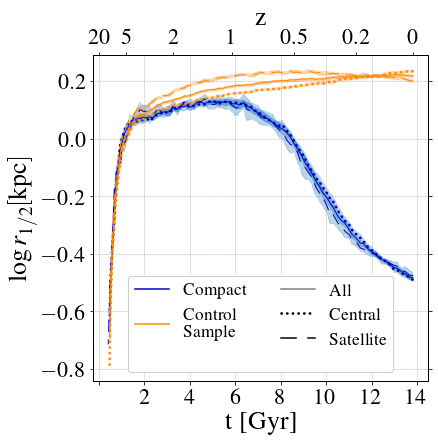

In [10]:
plot.PlotMedianEvolution(['Compact', 'CompactCentral', 'CompactSatellite', 'ControlSample', 'ControlSampleCentral', 'ControlSampleSatellite'],[''], ['SubhaloHalfmassRadType4'], Type = 'Evolution', SampleName='Samples' , dfName= 'Sample', savefigname='HalfRad', savepath='fig/Evol/Sample', ColumnPlot=True, limaxis=True, xlabelintext=False,  legend=True, LegendNames=[['Compact', 'ControlSample', 'None', 'All', 'Central', 'Satellite']], fontlegend=29)


We also can use this function to do co-evolution plots:

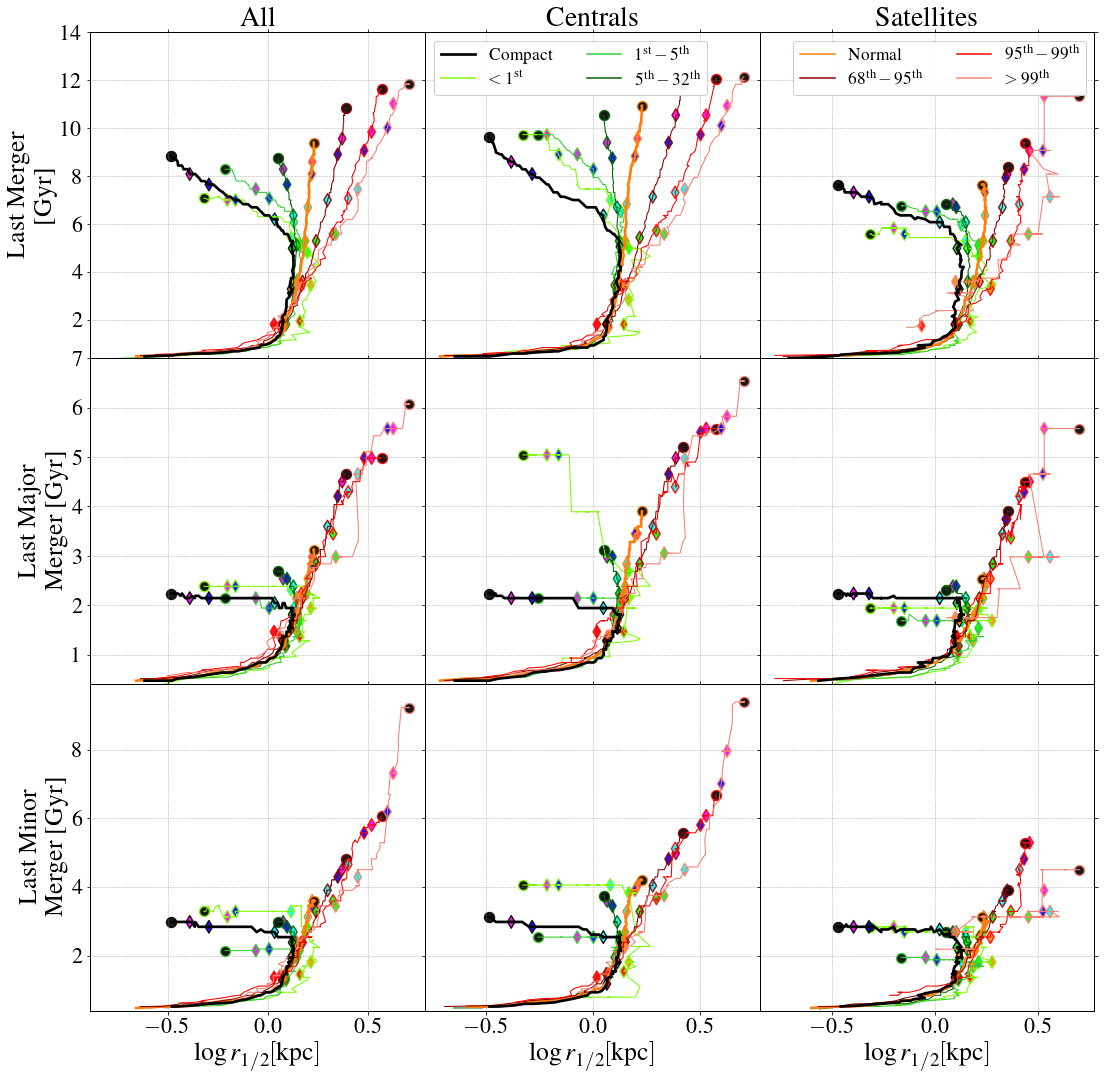

In [11]:
plot.PlotMedianEvolution(['3SigmaLower', '2SigmaLower', '1SigmaLower', 'NormalQuantile',   '1SigmaHigher', '2SigmaHigher', '3SigmaHigher', 'CompactQuantile'],  ['', 'Central', 'Satellite'],  ['LastMerger', 'LastMajorMerger', 'LastMinorMerger'], Type = 'CoEvolution', Xparam= ['SubhaloHalfmassRadType4', 'SubhaloHalfmassRadType4', 'SubhaloHalfmassRadType4'], SampleName='Quantile' , dfName= 'Sample', savefigname='LastMergerSize', savepath='fig/Evol', ColumnPlot=True, limaxis=False, xlabelintext=False,  legend=True, LegendNames=[[], ['CompactQuantile', '3SigmaLower', '2SigmaLower', '1SigmaLower'],[ 'Normal',   '1SigmaHigher', '2SigmaHigher', '3SigmaHigher']],  lineparams=False, loc=['best', 'best', 'best'], title = ['All', 'Centrals', 'Satellites'], fontlegend=29)


In this function the first element is an array with the main samples that will been plot. This main sample can be, for example, from the 'Samples' column in dfSample or 'Quantile', which is indicated in the argument 'SampleName'. The data file name is given in dfName. The second element is an array that indicated subdivision that will be show in differente column, like for example ['Central', 'Satellite'], which means that we have a column with central galaxies and another with satellites. If the value is given as [''] we have all the subhalos in one column. Finally the third element will be an array with the parameters that we wnat to see the evolution for each row. More complex plots can be made change some arguments. <br>
The argument Type indicate if the plot will be a median evolution or a median co-evolution, in this last case Xparam indicate the x param. 

### Random Evolution ###
To plot the evolution for a given subhalo we can do:

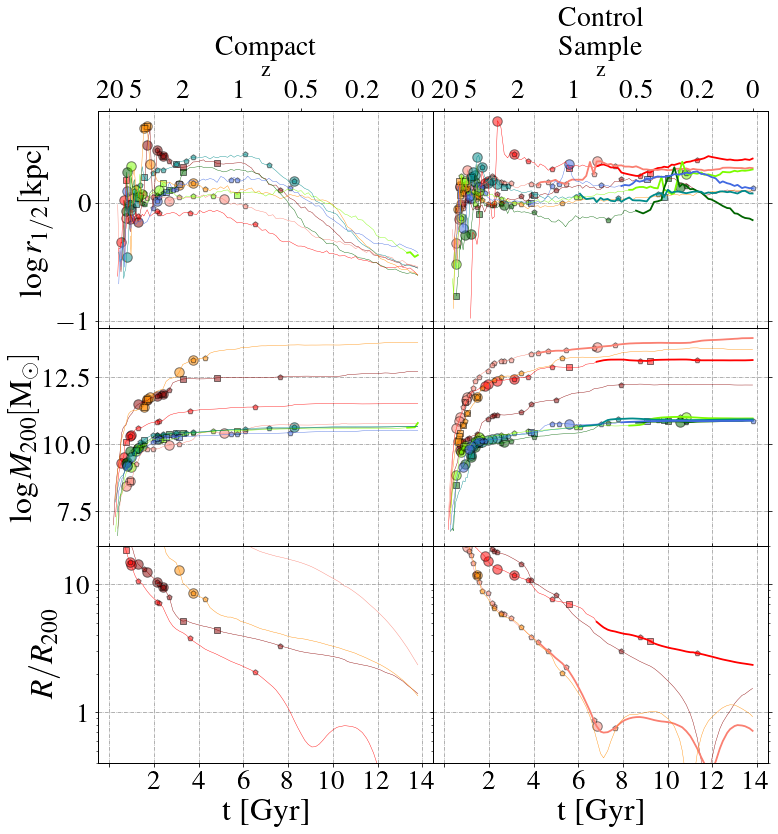

In [12]:
CompactIDs = np.array([379807, 625186, 725997,  96799, 754906,778666, 780425, 798987])
ControlSampleIDs = np.array([492245, 721829,  63914, 184983, 712763, 736231, 736455, 741473])
plot.PlotID(['Compact', 'ControlSample'],  ['SubhaloHalfmassRadType4', 'Group_M_Crit200', 'r_over_R_Crit200'], [CompactIDs, ControlSampleIDs], dataLine= 'SubhaloBHMass', dataMarker= 'NumMergersTotal', Type = 'Evolution', SampleName='Quantile' , dfName= 'Sample', savefigname='RandomCompact', savepath='fig/Evol', ColumnPlot=True, limaxis=False, xlabelintext=False,  legend=False, title=['Compact', 'ControlSample'], lineparams=False, loc='best', fontlabel = 32, QuantileError = False)


Here the first element give the Sample Name, the second the parameters and the third the array with the IDs for each Sample Name. Also, for this plot we can use dataLine to indicate the 'SubhaloBHMass.pkl' file, this will change the line thickeness if the galaxy have or not a BH. The dataMarker will use the 'NumMergers.pkl' files to plot when we have a merge as the different markers. We also have these arguments for the median population when we do:

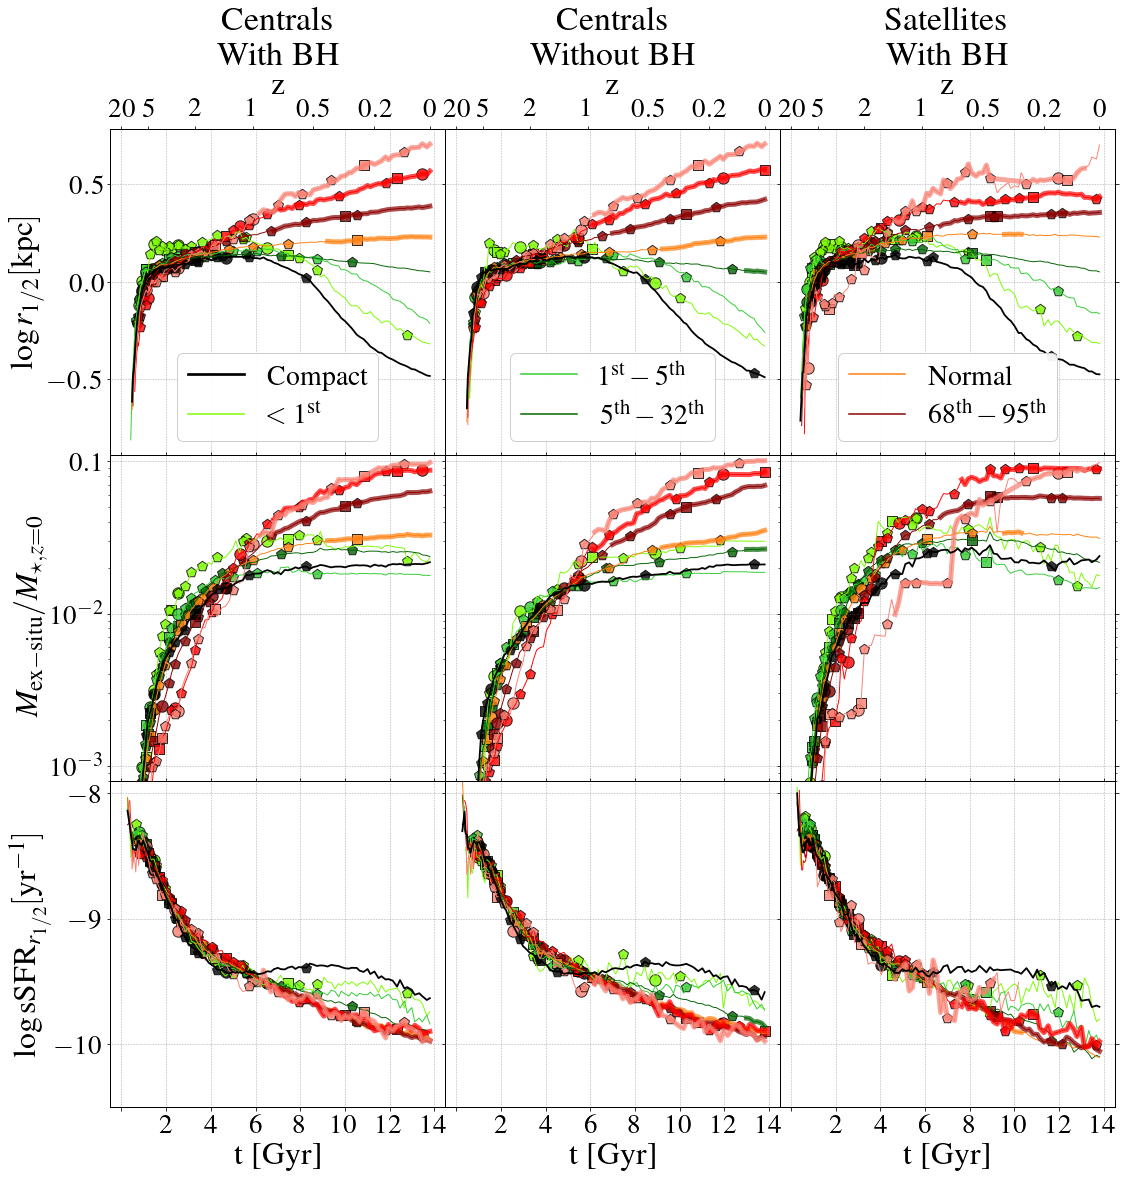

In [13]:
plot.PlotCustom(['3SigmaLower', '2SigmaLower', '1SigmaLower', 'Normal', '1SigmaHigher',  '2SigmaHigher',  '3SigmaHigher', 'CompactQuantile'],  ['',  'Central', 'Satellite'],  ['SubhaloHalfmassRadType4', 'MassExNormalizeAll', 'SubhalosSFRinHalfRad'], dataLine= 'SubhaloBHMass', dataMarker= 'NumMergersTotal', Type = 'Evolution', SampleName='Quantile' , dfName= 'Sample', savefigname='Central', savepath='fig/Evol', ColumnPlot=True, limaxis=False, xlabelintext=False,  legend=True, LegendNames=[['CompactQuantile', '3SigmaLower'], ['2SigmaLower', '1SigmaLower'], ['Normal', '1SigmaHigher'], [ '2SigmaHigher',  '3SigmaHigher']], title=['Centrals \n With BH', 'Centrals \n Without BH', 'Satellites \n With BH', 'Satellites \n Without BH'], lineparams=False, loc='best', QuantileError = False, fontlegend=28, fontlabel= 32, fontTitle=34)


## Radial Profile ##
In './data/Profiles/' we have data frame to plot the median radial profiles for the snapshots: 33, 40, 50, 59, 67, 78, 84, 99. These data were organized by selecting 10 random subhalos in each sample and compute the profiles by downloading the particle data from the TNG. This was done to facilitate access with this data. With that we can do, for example:

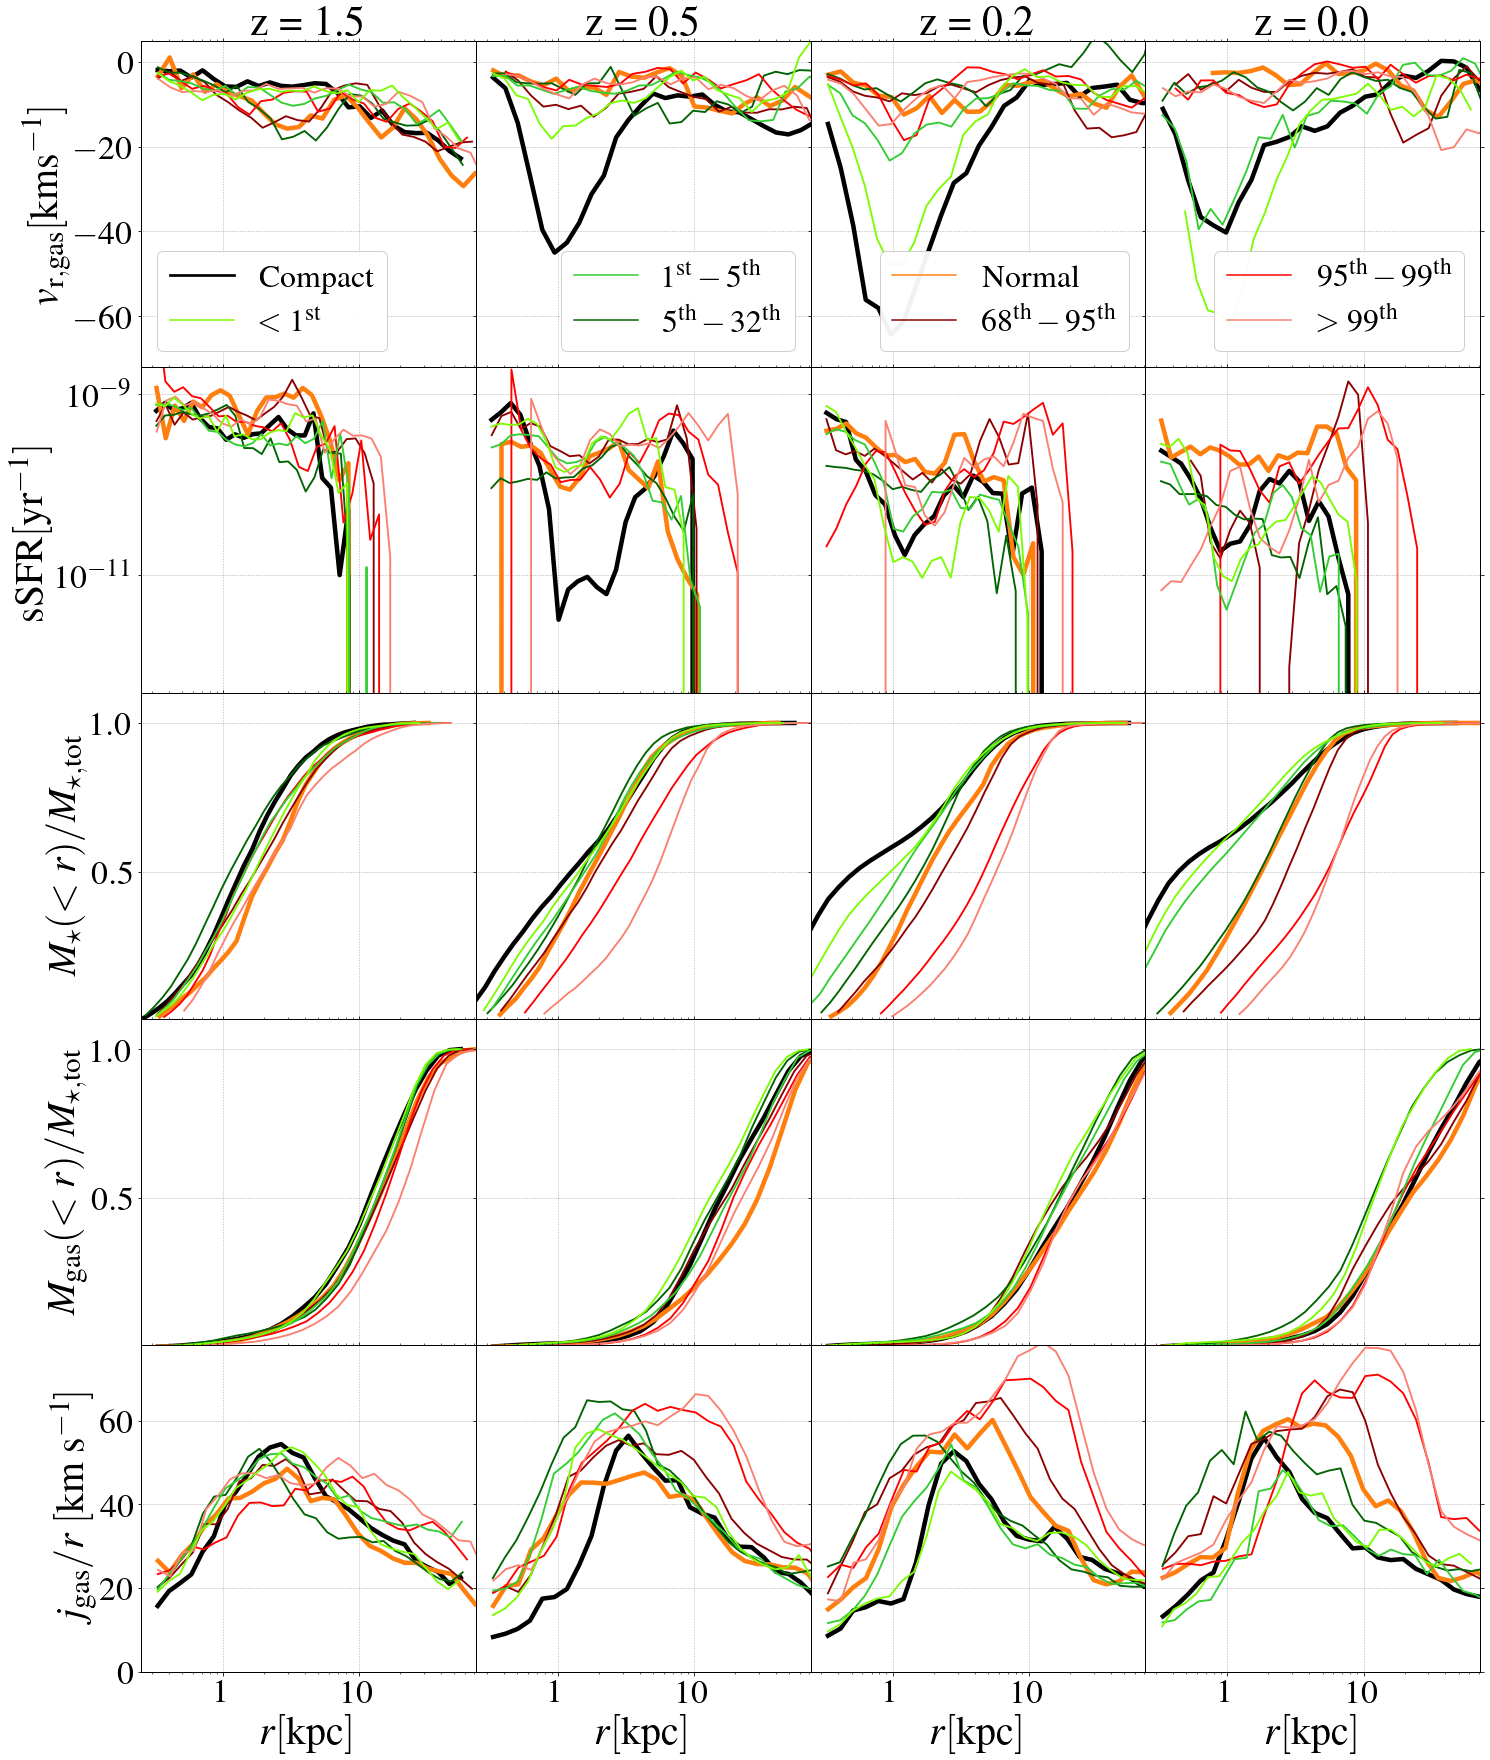

In [14]:
IDsCompact = np.array([143927, 757718, 760981, 558732, 738377, 468596, 752448, 785795, 736864, 724892])
IDs3SigmaLower = np.array([264904, 607119, 752046, 756982, 756982,    308, 805488, 578295, 645099, 764744])
IDs2SigmaLower = np.array([807220, 619802, 768012, 774656, 619802, 807220, 730197, 788825, 721013, 768160])
IDs1SigmaLower = np.array([793288, 744316, 793288, 754151, 744316, 754151, 744316, 793288, 793288, 754151])
IDsNormal = np.array([759917, 143946, 143946, 719927, 289399, 588987, 719927, 759917, 289399, 143946])
IDs1SigmaHigher = np.array([289411, 289411, 432111, 432111, 289411, 432111, 432111, 432111, 289411, 432111])
IDs2SigmaHigher = np.array([779893, 696147, 758154, 585518, 687721, 694124, 702925, 307492, 629093, 585518])
IDs3SigmaHigher = np.array([701644, 717670, 688299, 728769, 748925, 668713, 688299, 668713, 720668, 668962])

plot.PlotProfile([IDsCompact, IDsNormal, IDs1SigmaHigher, IDs1SigmaLower, IDs2SigmaHigher, IDs2SigmaLower, IDs3SigmaHigher, IDs3SigmaLower], ['CompactQuantileOld', 'NormalQuantile', '1SigmaHigher', '1SigmaLower', '2SigmaHigher', '2SigmaLower', '3SigmaHigher', '3SigmaLower'], [40, 67, 84, 99], ['RadVelocity', 'sSFR', 'Mstellar', 'Mgas', 'joverR'], ['PartType0', 'PartType0', 'PartType4', 'PartType0', 'PartType0', 'PartType0', 'PartType0', 'PartType0', 'PartType0', 'PartType0', 'PartType0', 'PartType0', 'PartType0', 'PartType0', 'PartType0'], Condition = 'Central', nbins = 28,   nboots = 50, savefigname = 'GasCentral', cumulative = True, legend=True, norm = True, LegendNames= [['CompactQuantile', '3SigmaLower'] ,  ['2SigmaLower', '1SigmaLower'], [ 'Normal', '1SigmaHigher'], ['2SigmaHigher',  '3SigmaHigher']], fontlegend=32, fontlabel= 40, fontTitle=42)
